In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device=torch.device('cpu')
print(device)

transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

cpu


In [3]:
train_path='C:/Users/dell/Desktop/paddyp/train'
test_path='C:/Users/dell/Desktop/paddyp/val'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [4]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)']


In [5]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=100):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=output.view(-1,32*75*75)
        output=self.fc(output)
        return output

In [6]:
model=ConvNet(num_classes=100).to(device)
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
num_epochs=20
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))
print(train_count,test_count)
best_accuracy=0.0

924 232


In [7]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    for i, (images,labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.data*images.size(0)
        _,prediction = torch.max(outputs.data,1)
        train_accuracy += int(torch.sum(prediction==labels.data))
    train_accuracy = train_accuracy/train_count
    train_loss = train_loss/train_count
    model.eval()
    
    test_accuracy = 0.0
    for i, (images,labels) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(images)
        _,prediction = torch.max(outputs.data,1)
        test_accuracy += int(torch.sum(prediction==labels.data))
    test_accuracy = test_accuracy/test_count
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy = test_accuracy
        
# Plot the training loss
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot the training and testing accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch: 0 Train Loss: tensor(8.5233) Train Accuracy: 0.5541125541125541 Test Accuracy: 0.6637931034482759
Epoch: 1 Train Loss: tensor(3.4295) Train Accuracy: 0.8084415584415584 Test Accuracy: 0.7586206896551724
Epoch: 2 Train Loss: tensor(1.9561) Train Accuracy: 0.8636363636363636 Test Accuracy: 0.7931034482758621
Epoch: 3 Train Loss: tensor(1.6274) Train Accuracy: 0.9025974025974026 Test Accuracy: 0.8362068965517241
Epoch: 4 Train Loss: tensor(0.7104) Train Accuracy: 0.920995670995671 Test Accuracy: 0.7844827586206896
Epoch: 5 Train Loss: tensor(1.7885) Train Accuracy: 0.8517316017316018 Test Accuracy: 0.8362068965517241
Epoch: 6 Train Loss: tensor(0.9479) Train Accuracy: 0.9253246753246753 Test Accuracy: 0.8232758620689655
Epoch: 7 Train Loss: tensor(0.5356) Train Accuracy: 0.935064935064935 Test Accuracy: 0.8232758620689655
Epoch: 8 Train Loss: tensor(0.3233) Train Accuracy: 0.9567099567099567 Test Accuracy: 0.875
Epoch: 9 Train Loss: tensor(0.3032) Train Accuracy: 0.9686147186147186

KeyboardInterrupt: 

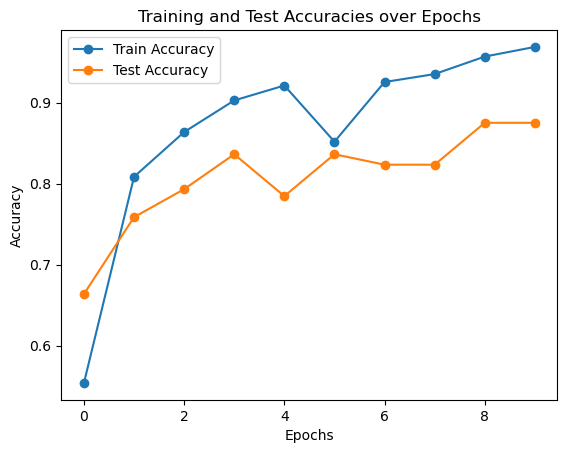

In [8]:
import matplotlib.pyplot as plt

epochs = list(range(10))
train_accuracy = [0.5541, 0.8084, 0.8636, 0.9026, 0.9210, 0.8517, 0.9253, 0.9351, 0.9567, 0.9686]
test_accuracy = [0.6638, 0.7586, 0.7931, 0.8362, 0.7845, 0.8362, 0.8233, 0.8233, 0.875, 0.875]

plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, test_accuracy, label='Test Accuracy', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies over Epochs')

plt.legend()

plt.show()


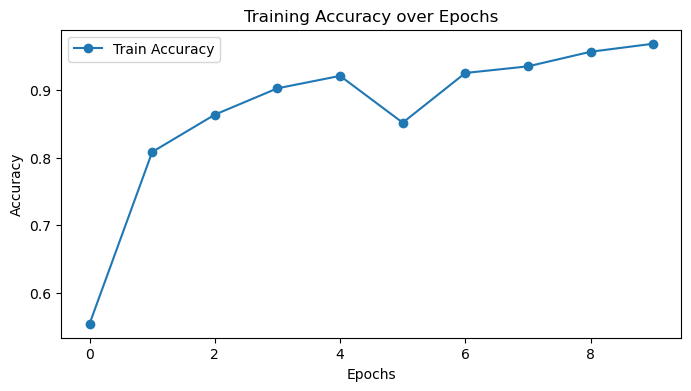

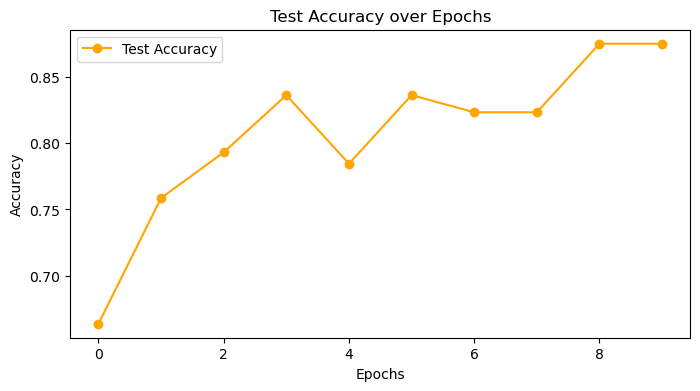

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs, test_accuracy, label='Test Accuracy', marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.show()